In [1]:
import glob
import csv
import sys, os.path
import pandas as pd
import sklearn
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision import transforms
#from torch.utils.tensorboard import SummaryWriter
#from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000

In [2]:
# Our modules
import sys
sys.path.append('.')
sys.path.append('..')

from vae import configs, train, plot_utils, models
from vae.data import build_dataloader
from vae.latent_spaces import dimensionality_reduction, plot_spaces
from vae.reconstructions import plot_reconstructions
from vae.models import model_utils

In [3]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [4]:
classes = ['violin', 'viola', 'cello', 'double-bass',
                'clarinet', 'bass-clarinet', 'saxophone', 'flute', 'oboe', 'bassoon', 'contrabassoon',
                'french-horn', 'trombone', 'trumpet', 'tuba', 'english-horn',
                'guitar', 'mandolin', 'banjo', 'chromatic-percussion']

chromatic_perc = ['agogo-bells', 'banana-shaker', 'bass-drum', 'bell-tree', 'cabasa', 'Chinese-hand-cymbals',
                        'castanets', 'Chinese-cymbal', 'clash-cymbals', 'cowbell', 'djembe', 'djundjun', 'flexatone', 'guiro',
                        'lemon-shaker',  'motor-horn',  'ratchet', 'sheeps-toenails', 'sizzle-cymbal', 'sleigh-bells', 'snare-drum',
                        'spring-coil', 'squeaker', 'strawberry-shaker', 'surdo', 'suspended-cymbal', 'swanee-whistle',
                        'tambourine', 'tam-tam', 'tenor-drum', 'Thai-gong', 'tom-toms', 'train-whistle', 'triangle',
                        'vibraslap', 'washboard', 'whip', 'wind-chimes', 'woodblock', 'cor-anglais']

labels_list = [i for i in range(len(classes))]

In [5]:
# Create dict of classes
classes_dict = {classes[i]: classes.index(classes[i]) for i in range(len(classes))}


df = pd.DataFrame.from_dict(classes_dict, orient='index', columns=['class'])

In [6]:
df

,class
violin,0
viola,1
cello,2
double-bass,3
clarinet,4
bass-clarinet,5
saxophone,6
flute,7
oboe,8
bassoon,9


In [7]:
model_name = 'supervised_timbre_fc-freq'
input = 'mel_cut'
trained_epochs = 20


test_dataset, test_dataloader = build_dataloader.build_testset(input, model_name)
print('Number of files in the training dataset:', len(test_dataset))

Number of files in the training dataset: 1357


In [8]:
model = model_utils.import_model(model_name, input)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
checkpoint = torch.load(os.path.join(configs.ParamsConfig.TRAINED_MODELS_PATH, 'saved_model_FreqFC.pth'))
model.load_state_dict(checkpoint['model'])
with torch.no_grad():
    model.eval()
    
    y_pred_list = []
    y_test_list = []
    for sample_batch, file, y in test_dataloader:
            sample_batch = sample_batch.to(device, dtype=torch.float)
            y_test_list.append(y)
            y_test_pred = model(sample_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
            
            #if y[0] == 0: #violins
                #plt.imshow(sample_batch[0,0,...].detach().cpu().numpy(), origin='lower', aspect=0.5)
                #plt.show()
                #plt.imshow(w[0,:,...].detach().cpu().numpy(), origin='lower')
                #plt.show()
                

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test = [a.squeeze().tolist() for a in y_test_list]

In [9]:
model_utils.show_total_params(model)

Number of parameters: 72852
AttentionTimbreFreqFC(
  (fc_0): Linear(in_features=128, out_features=128, bias=True)
  (fc_1): Linear(in_features=2816, out_features=20, bias=True)
)


In [10]:
assert y_pred_list != y_test

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_pred_list)

array([[74, 12,  0,  0,  1,  0, 30,  1,  5,  1,  0,  3,  4,  7,  0,  5,
         0,  0,  0,  7],
       [12, 37,  1,  2,  1,  0,  3,  3, 13,  0,  1,  4, 15,  3,  1,  0,
         0,  0,  0,  1],
       [ 6,  1, 25,  0,  0,  0,  3,  0,  4,  0, 12,  0, 11,  1, 19,  7,
         0,  0,  0,  0],
       [15,  1,  8, 44,  0,  0,  1,  0,  0,  0,  1,  2,  3,  0, 10,  0,
         0,  0,  0,  0],
       [18,  2,  4,  0,  5,  0, 14,  1,  4,  3,  0,  1, 21,  0,  0, 12,
         0,  0,  0,  0],
       [ 6,  0, 14, 31,  0,  9,  5,  0,  0, 10,  0,  0,  3,  0,  1, 15,
         0,  0,  0,  0],
       [18,  5,  2,  0,  1,  0,  5,  1,  1,  4,  0,  4, 21,  0,  1, 10,
         0,  0,  0,  0],
       [27,  5,  0,  0,  0,  0,  0,  6, 26,  0,  0,  3,  6,  7,  0,  8,
         0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  2, 49,  0,  0,  0,  4,  3,  0,  0,
         0,  0,  0,  0],
       [ 5,  1,  0,  0,  0,  2,  0,  0,  0, 35,  0, 20,  9,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  2, 23,  3,  0,  1

In [12]:
idx_class = {v: k for k, v in classes_dict.items()}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx_class, index=idx_class)

In [13]:
confusion_matrix_df

,violin,viola,cello,double-bass,clarinet,bass-clarinet,saxophone,flute,oboe,bassoon,contrabassoon,french-horn,trombone,trumpet,tuba,english-horn,guitar,mandolin,banjo,chromatic-percussion
violin,74,12,0,0,1,0,30,1,5,1,0,3,4,7,0,5,0,0,0,7
viola,12,37,1,2,1,0,3,3,13,0,1,4,15,3,1,0,0,0,0,1
cello,6,1,25,0,0,0,3,0,4,0,12,0,11,1,19,7,0,0,0,0
double-bass,15,1,8,44,0,0,1,0,0,0,1,2,3,0,10,0,0,0,0,0
clarinet,18,2,4,0,5,0,14,1,4,3,0,1,21,0,0,12,0,0,0,0
bass-clarinet,6,0,14,31,0,9,5,0,0,10,0,0,3,0,1,15,0,0,0,0
saxophone,18,5,2,0,1,0,5,1,1,4,0,4,21,0,1,10,0,0,0,0
flute,27,5,0,0,0,0,0,6,26,0,0,3,6,7,0,8,0,0,0,0
oboe,0,2,0,0,0,0,0,2,49,0,0,0,4,3,0,0,0,0,0,0
bassoon,5,1,0,0,0,2,0,0,0,35,0,20,9,0,0,0,0,0,0,0


<AxesSubplot:>

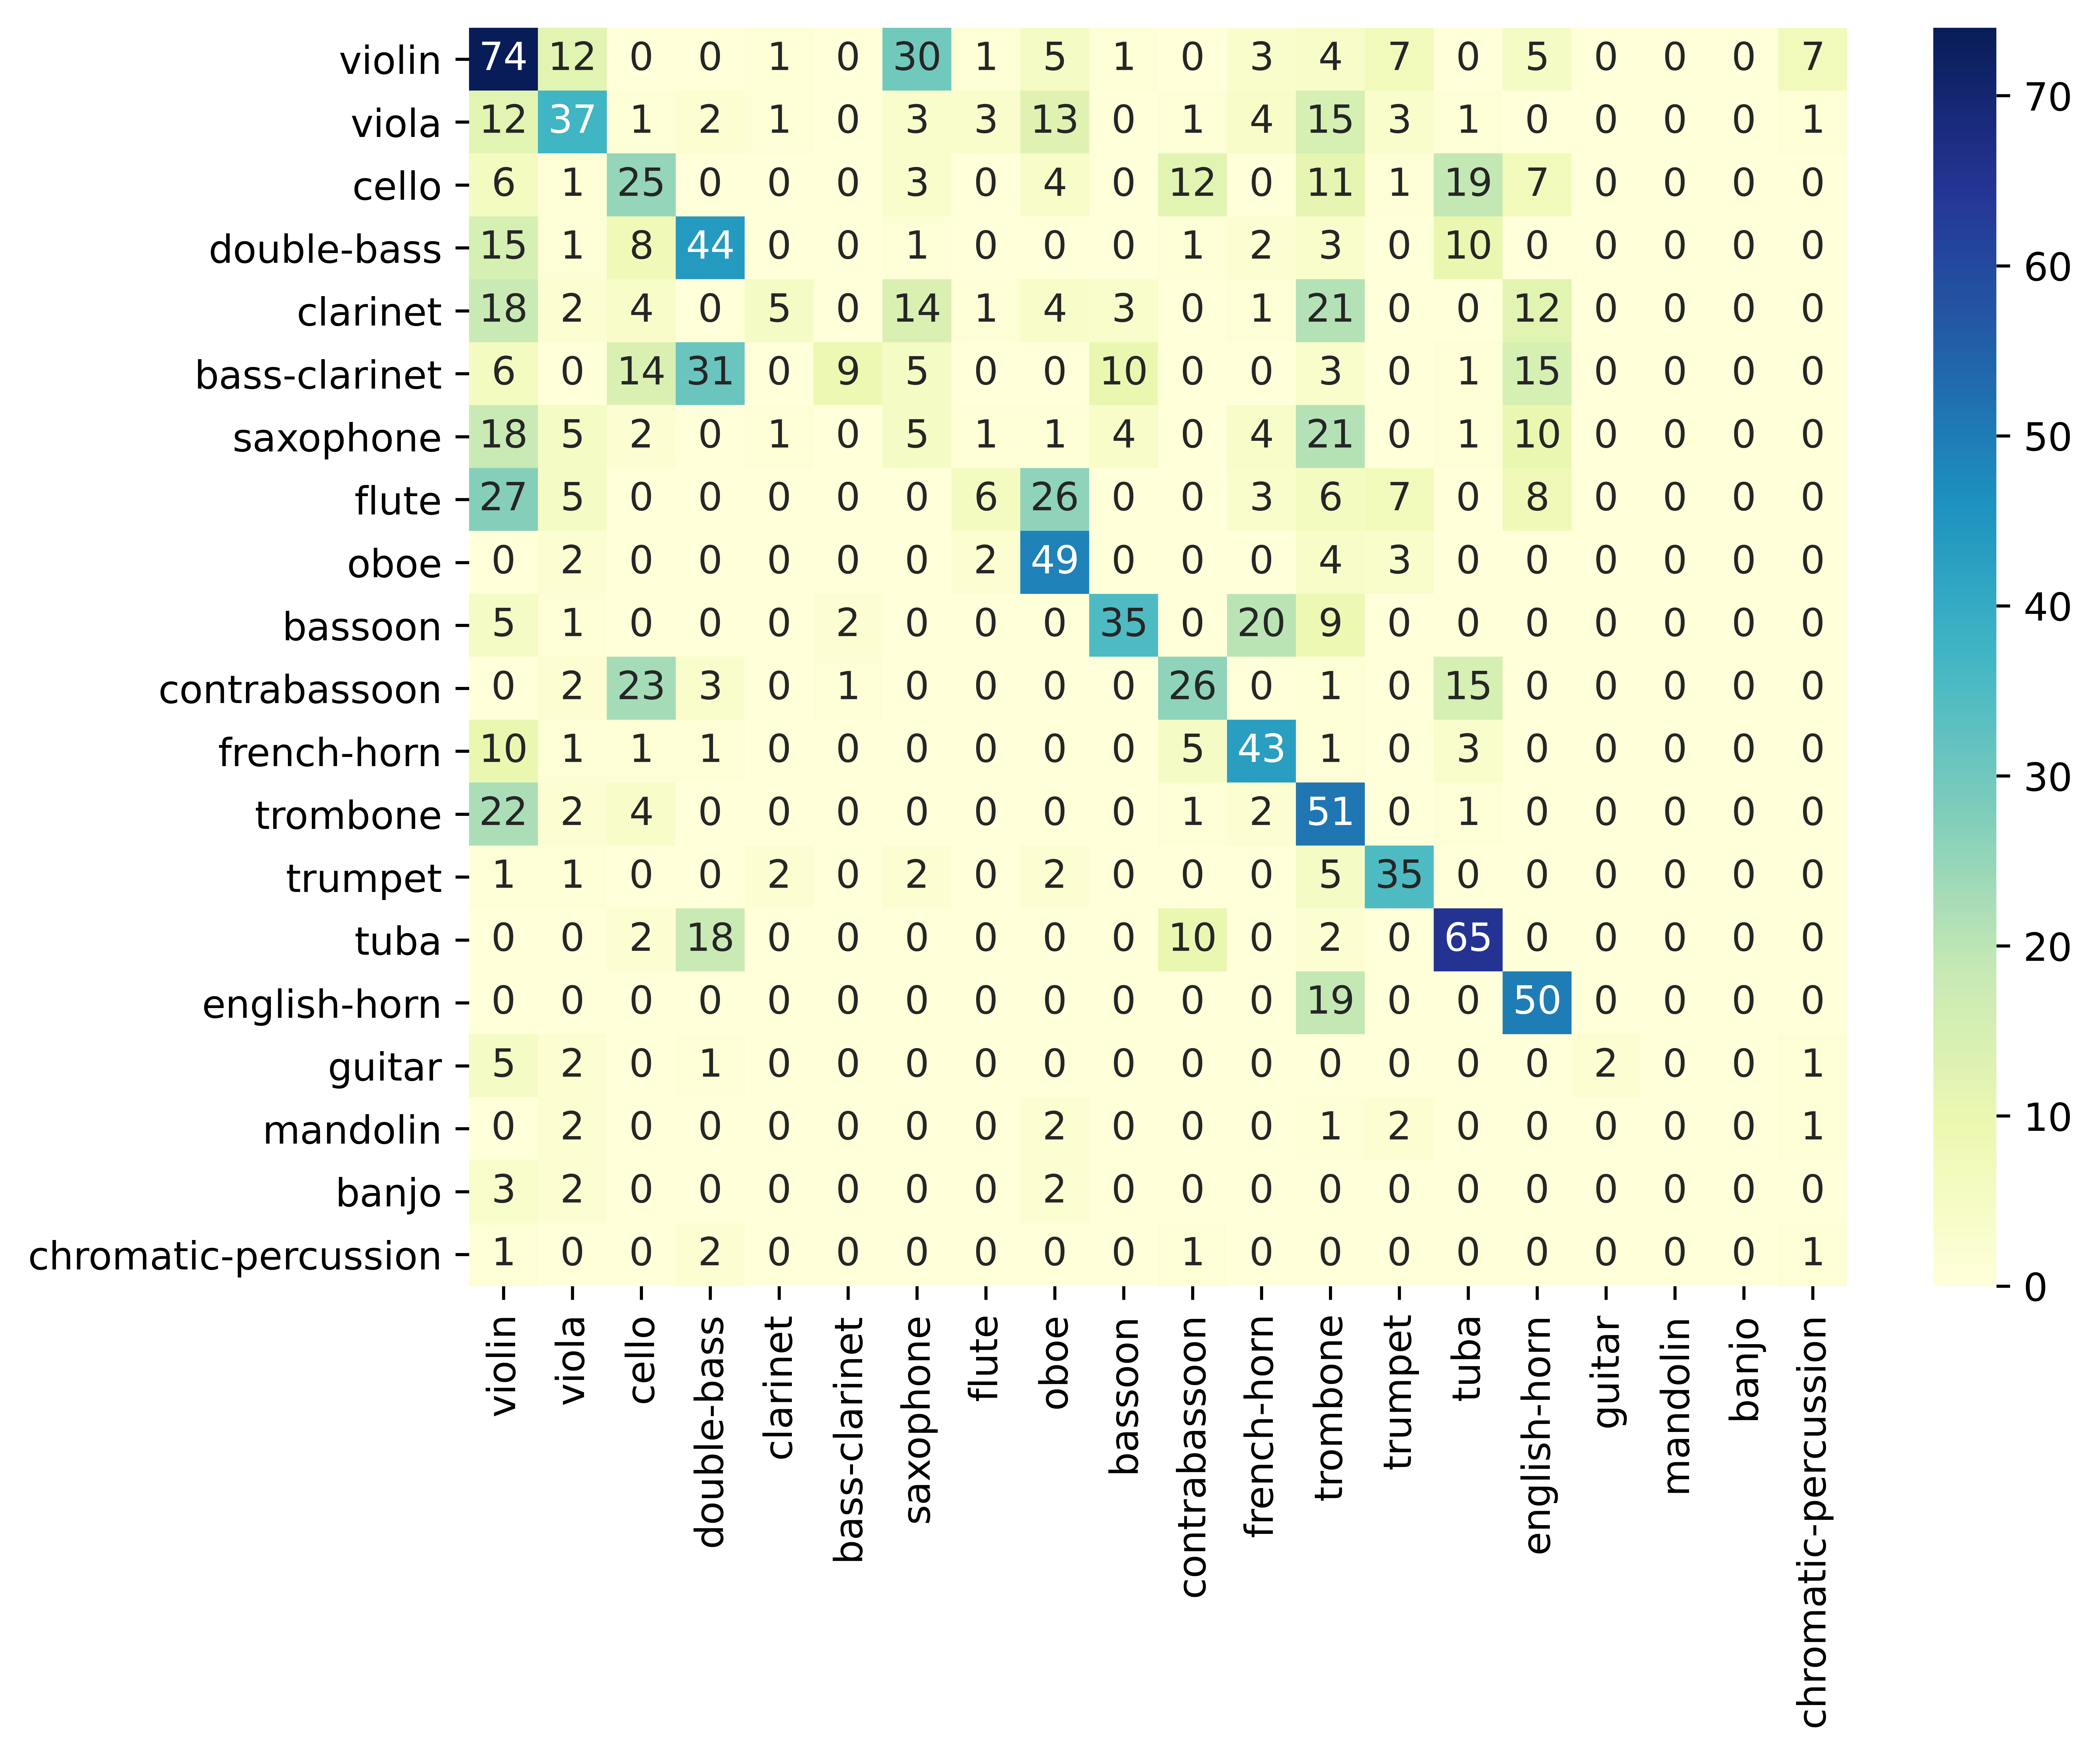

In [14]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(confusion_matrix_df, annot=True, cmap="YlGnBu", ax=ax)

<AxesSubplot:>

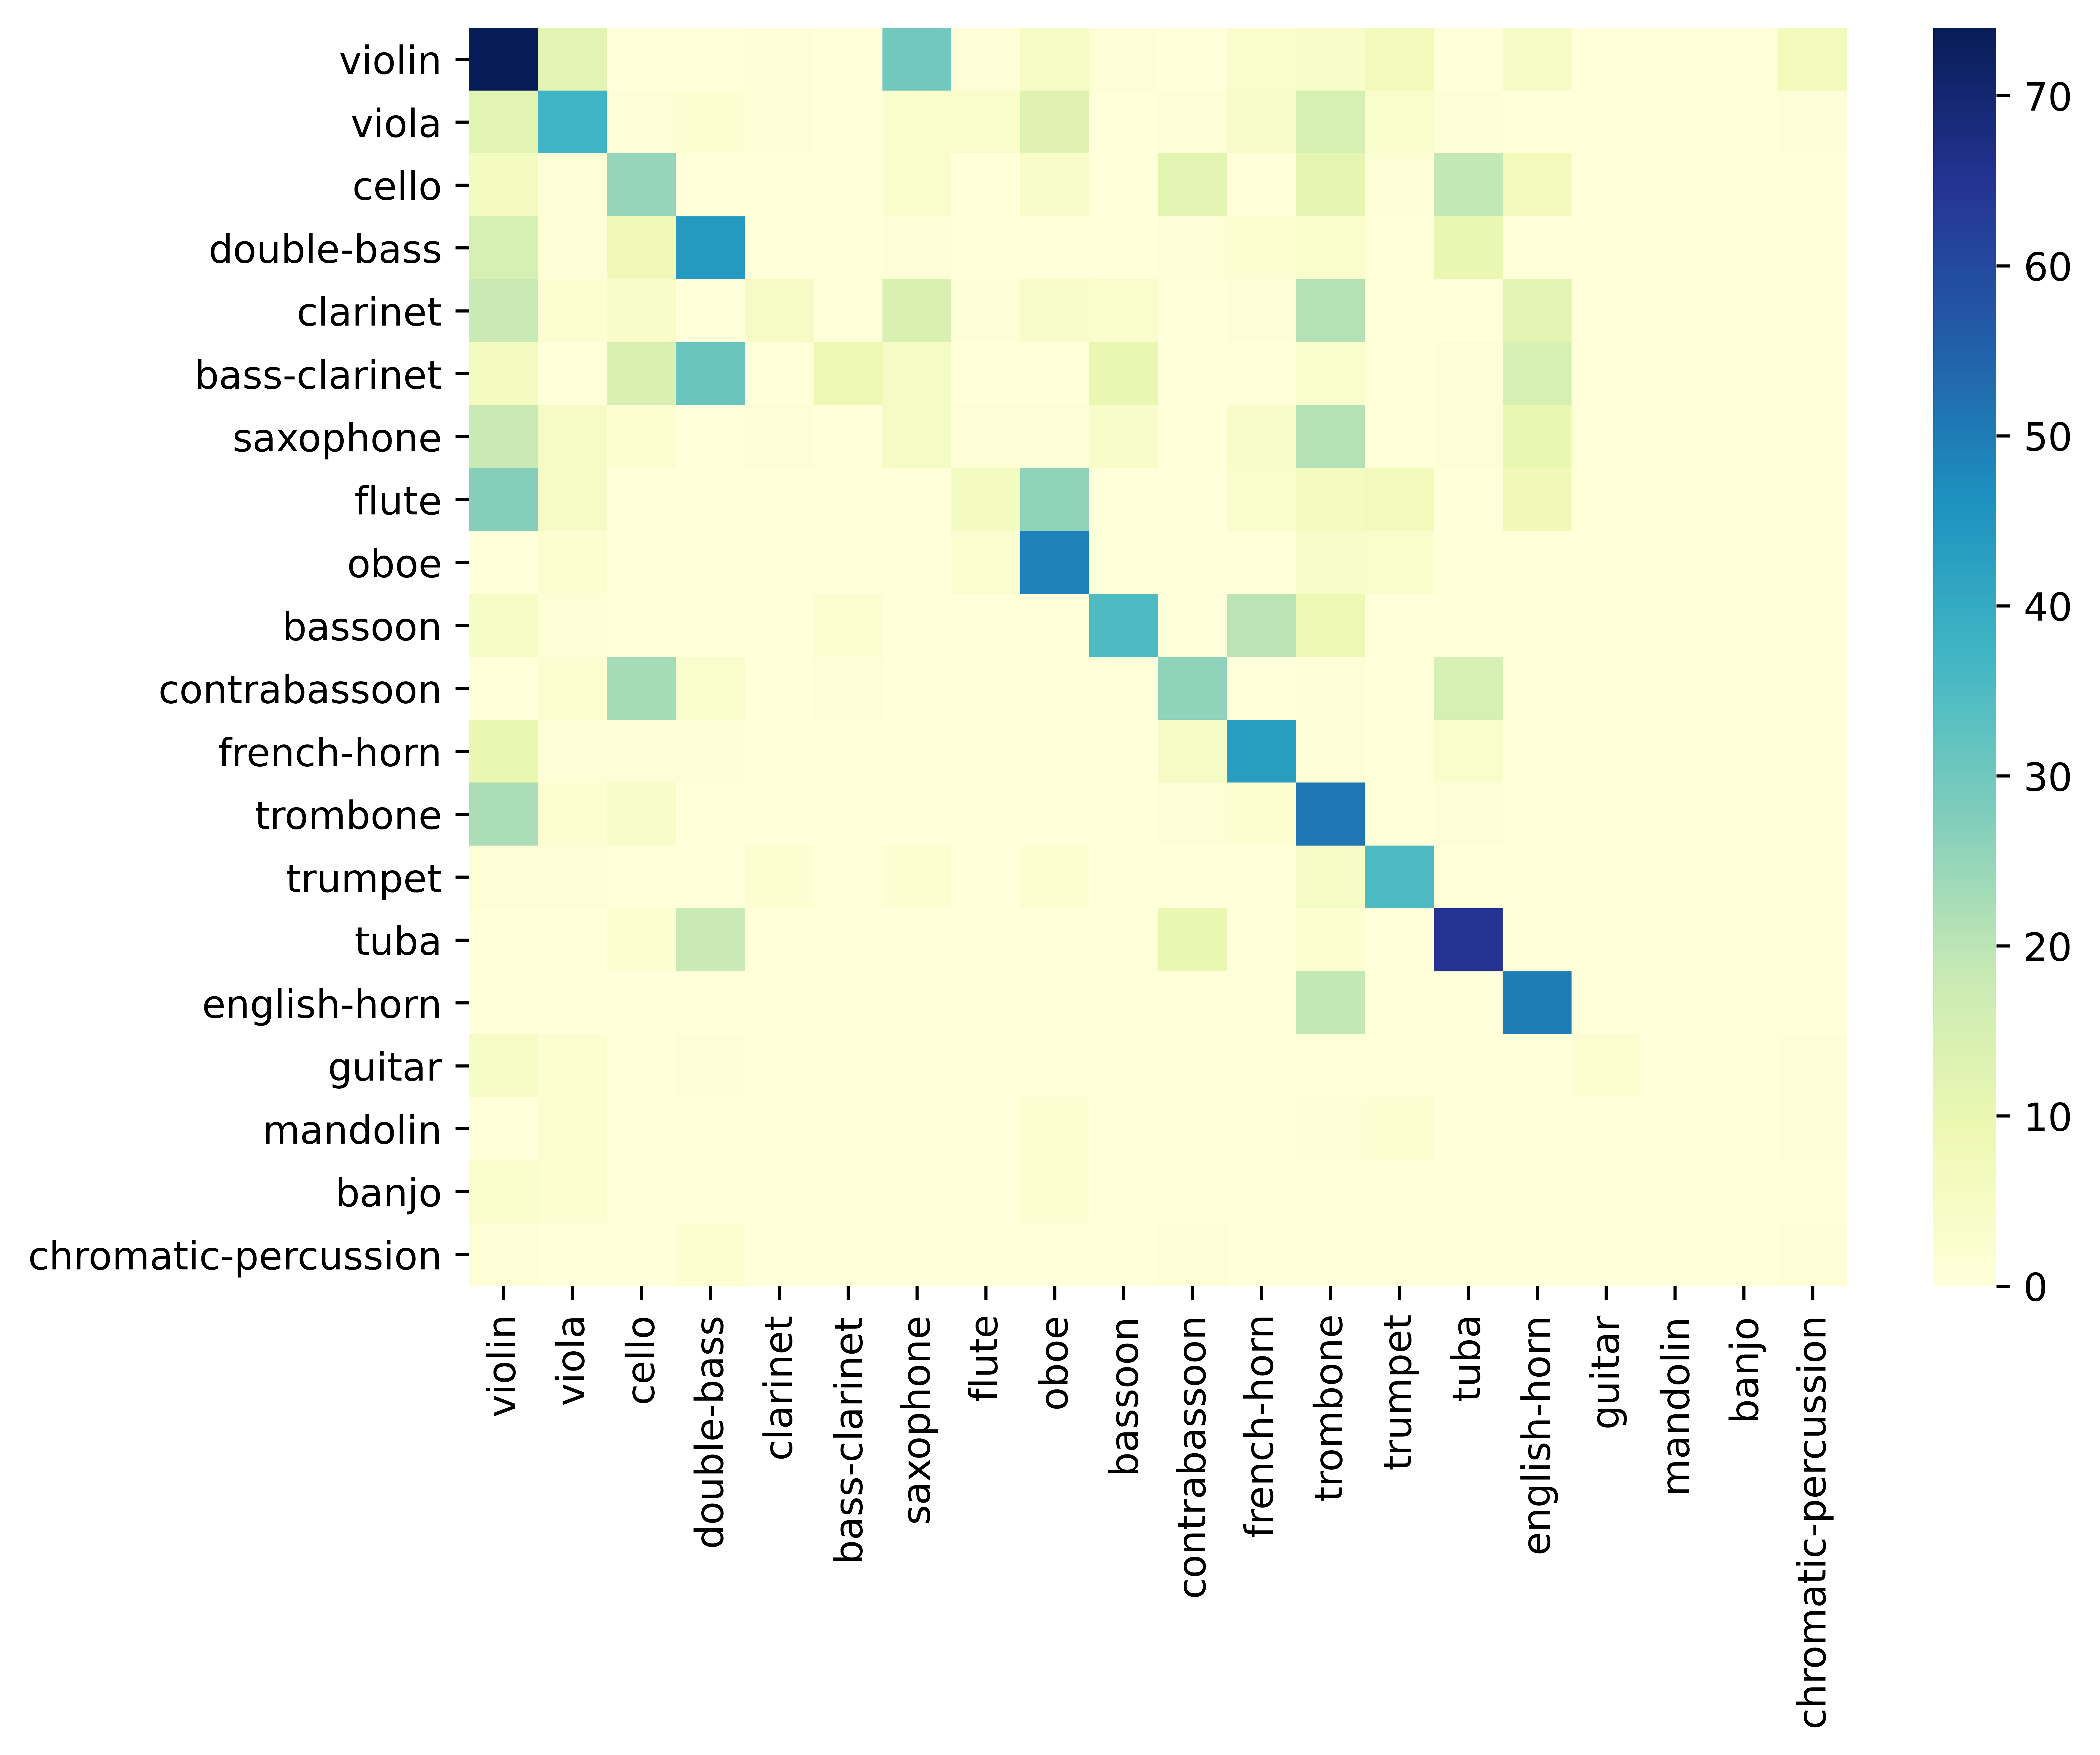

In [15]:
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(confusion_matrix_df, annot=False, cmap="YlGnBu", ax=ax)

In [22]:
path = 'H:\\INVESTIGACION\\Datasets\\London Philarmonic Orchestra\\'
set = 'validation'

In [23]:
chromatic_prec = ['agogo-bells', 'banana-shaker', 'bass-drum', 'bell-tree', 'cabasa', 'Chinese-hand-cymbals',
                        'castanets', 'Chinese-cymbal', 'clash-cymbals', 'cowbell', 'djembe', 'djundjun', 'flexatone', 'guiro',
                        'lemon-shaker',  'motor-horn',  'ratchet', 'sheeps-toenails', 'sizzle-cymbal', 'sleigh-bells', 'snare-drum',
                        'spring-coil', 'squeaker', 'strawberry-shaker', 'surdo', 'suspended-cymbal', 'swanee-whistle',
                        'tambourine', 'tam-tam', 'tenor-drum', 'Thai-gong', 'tom-toms', 'train-whistle', 'triangle',
                        'vibraslap', 'washboard', 'whip', 'wind-chimes', 'woodblock']
strings = ['violin', 'viola', 'cello', 'double-bass', 'banjo', 'guitar', 'mandolin']
woodwinds = ['clarinet', 'bass-clarinet', 'saxophone', 'flute', 'oboe', 'bassoon']
brass = ['english-horn', 'french-horn', 'trombone', 'trumpet', 'tuba']

In [24]:
from pathlib import Path

instruments = []
instruments_all = []
notes = []
notes_all = []
dynamics = []
dynamics_all = []
techniques = []
techniques_all = []
for (im_dirpath, im_dirnames, im_filenames) in os.walk(os.path.join(path, set)):
    for name in im_filenames:
        name_split = name.split('_')
        
        instrument = name_split[0]
        if instrument in chromatic_prec:
            instrument = 'chromatic-percussion'
        instruments_all.append(instrument)
        
        note = name_split[1]
        notes_all.append(note)
        
        dynamic = name_split[3]
        dynamics_all.append(dynamic)
        
        technique = name_split[4].split('.')[0]
        techniques_all.append(technique)
        
        if instrument not in instruments:
            instruments.append(instrument)
        if note not in notes:
            notes.append(note)
        if dynamic not in dynamics:
            dynamics.append(dynamic)
        if technique not in techniques:# and instrument in brass:
            techniques.append(technique)

print(instruments)        
print(notes)
print(dynamics)
print(techniques)

['banjo', 'bass-clarinet', 'chromatic-percussion', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
['Fs5', 'G3', 'G4', 'G5', 'Gs3', 'G2', 'Gs2', '', 'Fs4', 'G6', 'Gs4', 'G1', 'Gs1', 'G7']
['piano', 'forte', 'fortissimo', 'mezzo-forte', 'pianissimo', 'cresc-decresc', 'mezzo-piano', 'molto-pianissimo']
['normal', 'legato', 'nonlegato', 'staccato', 'tongued-slur', 'minor-trill', 'staccatissimo', 'major-trill', 'sticks', 'rhythm', 'fluttertonguing', 'tenuto', 'tremolo', 'arco-normal', 'molto-vibrato', 'arco-major-trill', 'arco-tremolo', 'arco-legato', 'arco-spiccato', 'arco-staccato', 'arco-detache', 'arco-minor-trill', 'struck-together', 'arco-col-legno-battuto', 'pizz-normal', 'natural-harmonic', 'glissando', 'double-tonguing', 'triple-tonguing', 'mute', 'harmonics', 'slap-tongue', 'without-snares', 'hand', 'non-vibrato', 'arco-glissando', '

In [25]:
count_instr = [instruments_all.count(instr) for instr in instruments]  

In [26]:
count_instr

[7, 94, 5, 72, 89, 85, 71, 85, 69, 88, 65, 11, 8, 60, 73, 83, 48, 97, 97, 150]

In [30]:
print(precision_recall_fscore_support(y_test, y_pred_list, labels=classes, average='weighted'))

(0.0, 0.0, 0.0, None)


## References

* https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab